## 4.5 权重衰减

考虑一些正则化技术缓解过拟合.

回想前面的多项式回归,我们可以通过调整拟合多项式的阶数来限制模型的容量  
多项式可以展开为单项式,而随着阶数 $d$ 的增加,展开后的项数迅速增加.若多项式中有 $k$ 项,则展开后有 $C^{k-1}_{k-1+d} = \frac{(k-1+d)!}{(d)!(k-1)!}$ 项&ensp;&ensp;因此不能简单地丢弃特征

<div style="background: #c6e6e8; border-left: 5px solid #22a2c3; padding: 10px; margin: 10px 0;">
<strong>THINK</strong><br>
降维呢?
</div>

### 4.5.1 范数与权重衰减

我们通过 $L_2$ 范数,以函数与0的距离度量函数复杂度.  
原本的损失:$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$
引入 $L_2$ 正则化后:$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2$$
其中, $\lambda$是非负的超参数,刻画正则化的程度; $\frac{1}{2}$ 与指数 $2$ 求导后约分简化计算

$L_2$正则化线性模型构成经典的**岭回归算法(ridge regression)**.

($L_1$正则化线性回归通常称作**套索回归(lasso regression)**. $L_1$正则化一般用于特征选择)

权重更新:$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

因为我们在更新权重 $\boldsymbol w$ 时在试图将 $\boldsymbol w$ 的大小缩小到0,所以也叫做**权重衰减**.  
较小的 $\lambda$ 对 $\boldsymbol w$ 的约束较小,较大的则约束较大

是否对偏置 $b^2$ 进行惩罚,在不同实践中会有所不同.通常,网络输出层的偏置项不会被正则化

### 4.5.2 高维线性回归

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

首先我们生成一些数据:$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$
为了使过拟合更明显,我们将维度增加到200,并使用只有20个样本的小训练集

```python
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise.

    Defined in :numref:`sec_utils`"""
    X = d2l.normal(0, 1, (num_examples, len(w)))
    y = d2l.matmul(X, w) + b
    y += d2l.normal(0, 0.01, y.shape)
    return X, d2l.reshape(y, (-1, 1))
```

In [2]:
n_train,n_test,num_inputs,batch_size=20,100,200,5
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05

train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.3 从0开始实现

#### 1.初始化模型参数

In [3]:
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]
#框架中通过 Sequential 实现

#### 2.定义$L_2$范数惩罚


In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

#### 3.定义训练代码实现

In [18]:
def train(lambd):
    w,b=init_params()
    net=lambda X:d2l.linreg(X,w,b)
    loss=d2l.squared_loss  #net和loss没有变化,所以这里省略了细节,直接用d2l
    num_epochs,lr=100,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                         xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X),y)+lambd*l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                  d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是:',torch.norm(w).item())

    return w,b

#torch.norm在将来可能被弃用, 建议用torch.linalg.matrix_norm或torch.linalg.vector_norm
#torch.Tensor.item: item() -> number

#### 4.忽略正则化直接训练

我们现在用`lambd=0`禁用权重衰减后训练:

w的L2范数是: 13.251275062561035


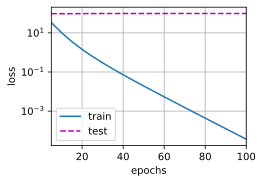

In [6]:
w,b=train(lambd=0)

In [7]:
w[:8],b

(tensor([[-0.7736],
         [ 0.6830],
         [-0.2018],
         [ 0.8546],
         [ 0.4892],
         [ 1.2463],
         [-0.0434],
         [-0.4331]], grad_fn=<SliceBackward0>),
 tensor([-0.2466], requires_grad=True))

可以看到严重的过拟合,训练误差在下降但是测试误差没有变化

#### 5.使用权重衰减

w的L2范数是: 0.3708140254020691


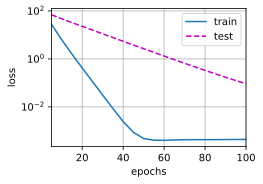

In [23]:
w,b=train(lambd=3)

In [9]:
w[:8],b

(tensor([[ 0.0194],
         [-0.0070],
         [ 0.0070],
         [ 0.0278],
         [ 0.0158],
         [-0.0553],
         [-0.0295],
         [-0.0160]], grad_fn=<SliceBackward0>),
 tensor([0.0214], requires_grad=True))

w的L2范数是: 0.3638981878757477
CPU times: user 2.04 s, sys: 14 ms, total: 2.05 s
Wall time: 2.04 s


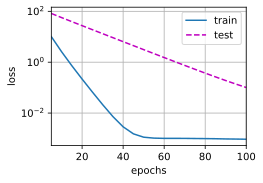

In [24]:
%time w,b=train(lambd=3)

后面训练误差不变甚至略有上升,而测试误差一直在减小.  
这正是我们期望正则化中得到的结果

### 4.5.4 简洁实现

深度学习框架将权重衰减集成到了优化算法中,以便与任何损失函数结合使用

默认情况下,PyTorch同时衰减权重和偏置,而这里我们只为weight设置了weight_decay

In [68]:
def train_concise(wd):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()

    loss=nn.MSELoss(reduction='none')
    num_epochs,lr=100,0.003

    #偏置参数没有衰减
    trainer=torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd},
        {"params":net[0].bias}],lr=lr)
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                          xlim=[5,num_epochs],legend=['train','test'])

    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1)%5==0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net,train_iter,loss),
                          d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数:',net[0].weight.norm().item())

w的L2范数: 14.555985450744629


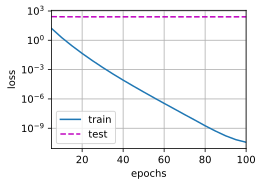

In [12]:
train_concise(0)

w的L2范数: 0.4026789665222168
CPU times: user 3.3 s, sys: 30 ms, total: 3.33 s
Wall time: 3.32 s


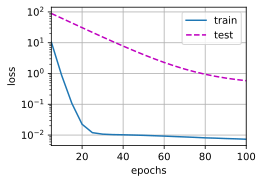

In [22]:
%time train_concise(3)

w的L2范数: 0.23126471042633057


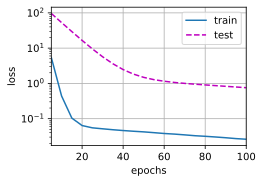

In [69]:
train_concise(5)

看似和手动实现结果相同,但是通过内置方法运行更快(我这里测试的结果会与计算机当时的状态有关)

注:实际中,正则化参数 $\lambda$ 往往比较小,这里是因为数据太特殊,20个样本,100维,所以 $\lambda$ 很大

到目前为止，我们只接触到一个简单线性函数的概念。此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。  
例如，再生核希尔伯特空间（RKHS） 允许在非线性环境中应用为线性函数引入的工具。  
不幸的是，基于RKHS的算法往往难以应用到大型、高维的数据。  
在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

>定理 6.1 表明，只要一个对称函数所对应的核矩阵半正定，它就能作为核函数使用.事实上，对于一个半正定核矩阵，总能找到一个与之对应的映射
$\phi$. 换言之，任何一个核函数都隐式地定义了一个称为"再生核希尔伯特空间" (Reproducing Kernel Hilbert Space ，简称 RKHS) 的特征空间.&emsp;[机器学习.周志华]

----
### PRACTICE

#### 1. 绘制训练和测试精度关于$\lambda$的函数图。

In [26]:
def draw_lambda(maxx):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()

    loss=nn.MSELoss(reduction='none')
    num_epochs,lr=100,0.003

    animator=d2l.Animator(xlabel='wd',ylabel='loss',yscale='log',
                          xlim=[0,maxx-1],legend=['train','test'])

    for wd in range(maxx):
        trainer=torch.optim.SGD([
            {"params":net[0].weight,'weight_decay':wd},
            {"params":net[0].bias}],lr=lr)
    
        for epoch in range(num_epochs):
            for X,y in train_iter:
                trainer.zero_grad()
                l=loss(net(X),y)
                l.mean().backward()
                trainer.step()
        
        animator.add(wd,
                     (d2l.evaluate_loss(net,train_iter,loss),
                      d2l.evaluate_loss(net,test_iter,loss)))


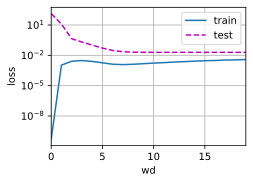

In [32]:
draw_lambda(20)

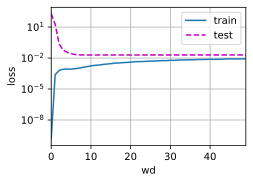

In [72]:
draw_lambda(50)

#### 2. 使用 $L_1$ 正则化

注: $L_1$ 正则化没有内置

In [38]:
def l1_penalty(w):
    return torch.sum(w.abs())

In [61]:
def train_l1(lambd):
    w,b=init_params()
    net=lambda X:d2l.linreg(X,w,b)
    loss=d2l.squared_loss  #net和loss没有变化,所以这里省略了细节,直接用d2l
    num_epochs,lr=150,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                         xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X),y)+lambd*l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                  d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L1范数是:',torch.norm(w).item())

    return w,b

w的L1范数是: 12.843513488769531


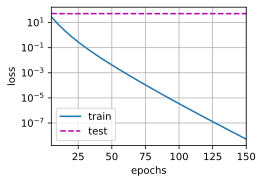

In [62]:
w,b=train_l1(0)

w的L1范数是: 0.07421363890171051


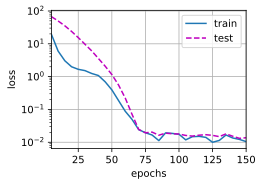

In [63]:
w,b=train_l1(3)

In [64]:
w.abs().mean(),w.max(),w.abs().min()

(tensor(0.0047, grad_fn=<MeanBackward0>),
 tensor(0.0090, grad_fn=<MaxBackward1>),
 tensor(1.0688e-05, grad_fn=<MinBackward1>))

w的L1范数是: 0.12058841437101364


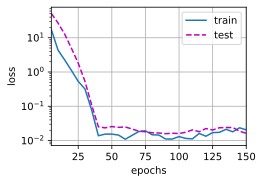

In [65]:
w,b=train_l1(5)

In [66]:
def draw_l1(maxx):
    w,b=init_params()
    net=lambda X:d2l.linreg(X,w,b)
    loss=d2l.squared_loss  #net和loss没有变化,所以这里省略了细节,直接用d2l
    num_epochs,lr=150,0.003
    animator=d2l.Animator(xlabel='lambda',ylabel='loss',yscale='log',
                         xlim=[0,maxx-1],legend=['train','test'])
    for lambd in range(maxx):
        for epoch in range(num_epochs):
            for X,y in train_iter:
                l=loss(net(X),y)+lambd*l1_penalty(w)
                l.sum().backward()
                d2l.sgd([w,b],lr,batch_size)

        animator.add(lambd,(d2l.evaluate_loss(net,train_iter,loss),
                        d2l.evaluate_loss(net,test_iter,loss)))


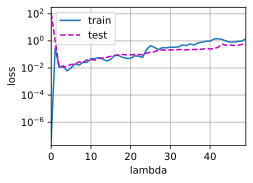

In [71]:
draw_l1(50)

<div style="background: #c6e6e8; border-left: 5px solid #22a2c3; padding: 10px; margin: 10px 0;">
<strong>THINK</strong><br>
1.从这两个练习来看,<br>
&emsp;&emsp;引入 \\(L_2\\) 正则化后,随着 $\lambda$ 的增大,test_loss不断减小,最终趋于稳定且趋近于train_loss.<br>
&emsp;&emsp;引入 \\(L_1\\) 正则化后,随着 $\lambda$ 的增大,test_loss先减小后增大.<br>
&emsp;&emsp; $L_2$ 正则化得到的曲线要比 $L_1$ 平滑<br>
2.增大 $\lambda$ 会加快train_loss的收敛
</div>

可能是数据太过极端?改变数据尝试:

In [75]:
n_train,n_test,num_inputs,batch_size=100,100,150,10
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05

train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

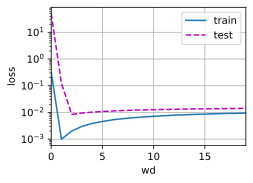

In [76]:
draw_lambda(20)

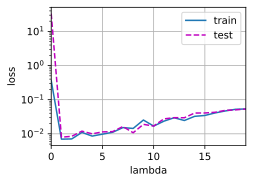

In [77]:
draw_l1(20)

<div style="background: #c6e6e8; border-left: 5px solid #22a2c3; padding: 10px; margin: 10px 0;">
<strong>THINK</strong><br>
    的确是第一次数据有些极端.<br>
    所以引入正则化时存在一个最优的$\lambda$<br><br>
    这里 $L_1$ 范数效果好一些,train_loss和test_loss也更接近<br>
</div>